In [1]:
import endomill
import yaml


In [2]:
parameter_packs = [
    {
        "MILL_TREATMENT_NAME": treatment,
        "MILL_REPLICATE": replicate,
    }
    for treatment in ["bag", "ring", "allopatry"]
    for replicate in range(10)
]


for i, pp in enumerate(parameter_packs):
    with open(f"species-inference-parameterization-{i}.yaml", "w") as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_TREATMENT_NAME: str
MILL_REPLICATE: int


In [4]:
# Parameters
MILL_REPLICATE = 3
MILL_TREATMENT_NAME = "ring"


# Global Setup


In [5]:
import copy
import math
import itertools as it
import typing
import random

import alifedata_phyloinformatics_convert as apc
from Bio import Phylo as BioPhylo
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools

from hstrat import hstrat
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
import sympy
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [6]:
random.seed(MILL_REPLICATE)


In [7]:
nbm.print_metadata()


context: local
hostname: thinkpad
interpreter: 3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
nbcellexec: null
nbname: None
nbpath: None
revision: null
session: b5ad3a82-823a-490d-8be0-aca7afd27f16
timestamp: 2023-05-23T19:25:38Z00:00




IPython==7.31.1
keyname==0.5.2
yaml==6.0
Bio==1.79
alifedata_phyloinformatics_convert==0.13.0
deap==1.3
endomill==0.1.3
hstrat==1.6.1
iterpop==0.4.1
matplotlib==3.6.2
nbmetalog==0.2.6
numpy==1.23.5
pandas==1.5.2
scipy==1.10.1
seaborn==0.12.1
sympy==1.9
teeplot==0.5.0
re==2.2.1
debugpy==1.6.6
logging==0.5.1.2
psutil==5.9.0
zmq==22.3.0
json==2.0.9
ipykernel==6.7.0


# Parameters


In [8]:
HSTRAT_DIFFERENTIA_WIDTH = 64
NGEN = 200
NPOP = 100
NTOURN = 2


# Setup


In [9]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register(
    "individual",
    deap_tools.initRepeat,
    deap_creator.Individual,
    toolbox.attr_bool,
    n=100,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (sum(individual),)


toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", deap_tools.cxTwoPoint)
toolbox.register("mutate", deap_tools.mutFlipBit, indpb=0.05)
toolbox.register("select", deap_tools.selTournament, tournsize=NTOURN)

# Decorate the variation operators
history = deap_tools.History()
toolbox.decorate("mate", history.decorator)

toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [10]:
# Create the population and populate the history
population = toolbox.population(n=NPOP)

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
gene_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
    initial_stratum_annotation=0,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = gene_ancestor.CloneDescendant(0)

history.update(population)

# Do the evolution, the decorators will take care of updating the
# history
if MILL_TREATMENT_NAME == "bag":
    for _gen in range(NGEN):
        offspring = deap_algorithms.varAnd(
            population,
            toolbox,
            cxpb=1.0,
            mutpb=1.0,
        )
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=NPOP)
        population = [copy.deepcopy(ind) for ind in population]

elif MILL_TREATMENT_NAME == "ring":
    NUM_ISLANDS = 10
    NUM_MIGRATIONS = 1
    slice_size = len(population) // NUM_ISLANDS
    for gen in tqdm(range(NGEN)):
        for slice_ in pylib.util.iter_slices(len(population), slice_size):
            subpopulation = population[slice_]
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            population[slice_] = [copy.deepcopy(ind) for ind in subpopulation]

        for m in range(NUM_MIGRATIONS):
            displacement = random.randrange(slice_size, 2 * slice_size)
            a = random.randrange(len(population))
            b = (a + displacement) % len(population)
            population[a], population[b] = population[b], population[a]

    from_subpopulations = []
    for i in range(0, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        from_subpopulations.extend(subpopulation)
    population = from_subpopulations

elif MILL_TREATMENT_NAME == "allopatry":
    # sympatry
    for gen in tqdm(range(NGEN // 2)):
        offspring = deap_algorithms.varAnd(
            population, toolbox, cxpb=1.0, mutpb=1.0
        )
        fits = toolbox.map(toolbox.evaluate, offspring)

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        population = [copy.deepcopy(ind) for ind in population]

    # two-island allopatry
    slice_size = NPOP // 2
    from_subpopulations = []
    for i in range(0, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)
    population = from_subpopulations

    # three-island allopatry: left island
    slice_size = NPOP // 2
    from_subpopulations = []
    for i in range(0, len(population) // 2, slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)

    # three-island allopatry: right five islands
    slice_size = NPOP // 10
    for i in range(len(population) // 2, len(population), slice_size):
        subpopulation = population[i : i + slice_size]
        for gen in tqdm(range(NGEN // 4)):
            offspring = deap_algorithms.varAnd(
                subpopulation, toolbox, cxpb=1.0, mutpb=1.0
            )
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            subpopulation = toolbox.select(offspring, k=len(subpopulation))
            subpopulation = [copy.deepcopy(ind) for ind in subpopulation]

        from_subpopulations.extend(subpopulation)

    population = from_subpopulations

else:
    assert False, MILL_TREATMENT_NAME

# ensure all extant organisms registered with phylogeny tracker
for x in population:
    history.update([x])


  0%|                                                                                                                                                                 | 0/200 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                        | 1/200 [00:00<01:54,  1.73it/s]

  1%|█▌                                                                                                                                                       | 2/200 [00:01<01:43,  1.91it/s]

  2%|██▎                                                                                                                                                      | 3/200 [00:01<01:50,  1.78it/s]

  2%|███                                                                                                                                                      | 4/200 [00:02<01:53,  1.72it/s]

  2%|███▊                                                                                                                                                     | 5/200 [00:03<02:14,  1.45it/s]

  3%|████▌                                                                                                                                                    | 6/200 [00:03<02:16,  1.42it/s]

  4%|█████▎                                                                                                                                                   | 7/200 [00:04<02:06,  1.52it/s]

  4%|██████                                                                                                                                                   | 8/200 [00:05<02:02,  1.56it/s]

  4%|██████▉                                                                                                                                                  | 9/200 [00:05<02:01,  1.57it/s]

  5%|███████▌                                                                                                                                                | 10/200 [00:06<02:02,  1.55it/s]

  6%|████████▎                                                                                                                                               | 11/200 [00:06<01:51,  1.69it/s]

  6%|█████████                                                                                                                                               | 12/200 [00:07<01:50,  1.70it/s]

  6%|█████████▉                                                                                                                                              | 13/200 [00:08<02:06,  1.48it/s]

  7%|██████████▋                                                                                                                                             | 14/200 [00:09<02:17,  1.36it/s]

  8%|███████████▍                                                                                                                                            | 15/200 [00:10<02:26,  1.26it/s]

  8%|████████████▏                                                                                                                                           | 16/200 [00:11<02:33,  1.20it/s]

  8%|████████████▉                                                                                                                                           | 17/200 [00:11<02:39,  1.15it/s]

  9%|█████████████▋                                                                                                                                          | 18/200 [00:13<03:05,  1.02s/it]

 10%|██████████████▍                                                                                                                                         | 19/200 [00:14<03:04,  1.02s/it]

 10%|███████████████▏                                                                                                                                        | 20/200 [00:15<03:04,  1.02s/it]

 10%|███████████████▉                                                                                                                                        | 21/200 [00:16<03:05,  1.04s/it]

 11%|████████████████▋                                                                                                                                       | 22/200 [00:17<03:02,  1.02s/it]

 12%|█████████████████▍                                                                                                                                      | 23/200 [00:18<03:05,  1.05s/it]

 12%|██████████████████▏                                                                                                                                     | 24/200 [00:19<03:09,  1.08s/it]

 12%|███████████████████                                                                                                                                     | 25/200 [00:20<03:12,  1.10s/it]

 13%|███████████████████▊                                                                                                                                    | 26/200 [00:22<03:35,  1.24s/it]

 14%|████████████████████▌                                                                                                                                   | 27/200 [00:23<03:34,  1.24s/it]

 14%|█████████████████████▎                                                                                                                                  | 28/200 [00:24<03:33,  1.24s/it]

 14%|██████████████████████                                                                                                                                  | 29/200 [00:26<03:34,  1.25s/it]

 15%|██████████████████████▊                                                                                                                                 | 30/200 [00:27<03:56,  1.39s/it]

 16%|███████████████████████▌                                                                                                                                | 31/200 [00:29<03:41,  1.31s/it]

 16%|████████████████████████▎                                                                                                                               | 32/200 [00:30<03:42,  1.32s/it]

 16%|█████████████████████████                                                                                                                               | 33/200 [00:31<03:44,  1.35s/it]

 17%|█████████████████████████▊                                                                                                                              | 34/200 [00:33<04:10,  1.51s/it]

 18%|██████████████████████████▌                                                                                                                             | 35/200 [00:35<04:05,  1.49s/it]

 18%|███████████████████████████▎                                                                                                                            | 36/200 [00:36<04:01,  1.48s/it]

 18%|████████████████████████████                                                                                                                            | 37/200 [00:37<03:54,  1.44s/it]

 19%|████████████████████████████▉                                                                                                                           | 38/200 [00:39<03:56,  1.46s/it]

 20%|█████████████████████████████▋                                                                                                                          | 39/200 [00:41<04:24,  1.64s/it]

 20%|██████████████████████████████▍                                                                                                                         | 40/200 [00:43<04:21,  1.63s/it]

 20%|███████████████████████████████▏                                                                                                                        | 41/200 [00:44<04:18,  1.63s/it]

 21%|███████████████████████████████▉                                                                                                                        | 42/200 [00:46<04:17,  1.63s/it]

 22%|████████████████████████████████▋                                                                                                                       | 43/200 [00:48<04:41,  1.79s/it]

 22%|█████████████████████████████████▍                                                                                                                      | 44/200 [00:50<04:36,  1.77s/it]

 22%|██████████████████████████████████▏                                                                                                                     | 45/200 [00:51<04:31,  1.75s/it]

 23%|██████████████████████████████████▉                                                                                                                     | 46/200 [00:53<04:29,  1.75s/it]

 24%|███████████████████████████████████▋                                                                                                                    | 47/200 [00:55<04:28,  1.76s/it]

 24%|████████████████████████████████████▍                                                                                                                   | 48/200 [00:57<04:55,  1.94s/it]

 24%|█████████████████████████████████████▏                                                                                                                  | 49/200 [00:59<04:48,  1.91s/it]

 25%|██████████████████████████████████████                                                                                                                  | 50/200 [01:01<04:44,  1.90s/it]

 26%|██████████████████████████████████████▊                                                                                                                 | 51/200 [01:03<04:41,  1.89s/it]

 26%|███████████████████████████████████████▌                                                                                                                | 52/200 [01:05<05:07,  2.08s/it]

 26%|████████████████████████████████████████▎                                                                                                               | 53/200 [01:07<04:58,  2.03s/it]

 27%|█████████████████████████████████████████                                                                                                               | 54/200 [01:09<04:54,  2.02s/it]

 28%|█████████████████████████████████████████▊                                                                                                              | 55/200 [01:11<04:51,  2.01s/it]

 28%|██████████████████████████████████████████▌                                                                                                             | 56/200 [01:13<04:50,  2.01s/it]

 28%|███████████████████████████████████████████▎                                                                                                            | 57/200 [01:16<05:17,  2.22s/it]

 29%|████████████████████████████████████████████                                                                                                            | 58/200 [01:18<05:09,  2.18s/it]

 30%|████████████████████████████████████████████▊                                                                                                           | 59/200 [01:20<05:04,  2.16s/it]

 30%|█████████████████████████████████████████████▌                                                                                                          | 60/200 [01:22<05:00,  2.15s/it]

 30%|██████████████████████████████████████████████▎                                                                                                         | 61/200 [01:25<04:58,  2.15s/it]

 31%|███████████████████████████████████████████████                                                                                                         | 62/200 [01:27<05:27,  2.37s/it]

 32%|███████████████████████████████████████████████▉                                                                                                        | 63/200 [01:30<05:18,  2.33s/it]

 32%|████████████████████████████████████████████████▋                                                                                                       | 64/200 [01:32<05:13,  2.30s/it]

 32%|█████████████████████████████████████████████████▍                                                                                                      | 65/200 [01:34<05:09,  2.29s/it]

 33%|██████████████████████████████████████████████████▏                                                                                                     | 66/200 [01:36<05:07,  2.29s/it]

 34%|██████████████████████████████████████████████████▉                                                                                                     | 67/200 [01:40<05:36,  2.53s/it]

 34%|███████████████████████████████████████████████████▋                                                                                                    | 68/200 [01:42<05:27,  2.48s/it]

 34%|████████████████████████████████████████████████████▍                                                                                                   | 69/200 [01:44<05:21,  2.45s/it]

 35%|█████████████████████████████████████████████████████▏                                                                                                  | 70/200 [01:46<04:56,  2.28s/it]

 36%|█████████████████████████████████████████████████████▉                                                                                                  | 71/200 [01:48<04:33,  2.12s/it]

 36%|██████████████████████████████████████████████████████▋                                                                                                 | 72/200 [01:50<04:43,  2.22s/it]

 36%|███████████████████████████████████████████████████████▍                                                                                                | 73/200 [01:52<04:25,  2.09s/it]

 37%|████████████████████████████████████████████████████████▏                                                                                               | 74/200 [01:54<04:13,  2.01s/it]

 38%|█████████████████████████████████████████████████████████                                                                                               | 75/200 [01:56<04:05,  1.96s/it]

 38%|█████████████████████████████████████████████████████████▊                                                                                              | 76/200 [01:58<04:00,  1.94s/it]

 38%|██████████████████████████████████████████████████████████▌                                                                                             | 77/200 [02:00<04:22,  2.14s/it]

 39%|███████████████████████████████████████████████████████████▎                                                                                            | 78/200 [02:02<04:13,  2.08s/it]

 40%|████████████████████████████████████████████████████████████                                                                                            | 79/200 [02:04<04:05,  2.03s/it]

 40%|████████████████████████████████████████████████████████████▊                                                                                           | 80/200 [02:06<04:01,  2.01s/it]

 40%|█████████████████████████████████████████████████████████████▌                                                                                          | 81/200 [02:08<03:57,  2.00s/it]

 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 82/200 [02:11<04:22,  2.23s/it]

 42%|███████████████████████████████████████████████████████████████                                                                                         | 83/200 [02:13<04:13,  2.17s/it]

 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 84/200 [02:15<04:07,  2.13s/it]

 42%|████████████████████████████████████████████████████████████████▌                                                                                       | 85/200 [02:17<04:03,  2.12s/it]

 43%|█████████████████████████████████████████████████████████████████▎                                                                                      | 86/200 [02:19<04:00,  2.11s/it]

 44%|██████████████████████████████████████████████████████████████████                                                                                      | 87/200 [02:21<03:57,  2.11s/it]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 88/200 [02:24<04:25,  2.37s/it]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                    | 89/200 [02:26<04:16,  2.31s/it]

 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 90/200 [02:29<04:09,  2.27s/it]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                                  | 91/200 [02:31<04:05,  2.25s/it]

 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 92/200 [02:33<04:07,  2.29s/it]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                 | 93/200 [02:37<05:06,  2.87s/it]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 94/200 [02:40<04:56,  2.80s/it]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                               | 95/200 [02:42<04:41,  2.69s/it]

 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 96/200 [02:46<04:55,  2.84s/it]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                              | 97/200 [02:49<05:04,  2.95s/it]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 98/200 [02:52<05:09,  3.04s/it]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 99/200 [02:57<05:49,  3.46s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 100/200 [03:00<05:41,  3.41s/it]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 101/200 [03:03<05:35,  3.39s/it]

 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 102/200 [03:06<05:30,  3.37s/it]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 103/200 [03:10<05:27,  3.38s/it]

 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 104/200 [03:15<06:01,  3.76s/it]

 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 105/200 [03:18<05:48,  3.67s/it]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 106/200 [03:21<05:40,  3.62s/it]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 107/200 [03:25<05:33,  3.59s/it]

 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 108/200 [03:28<05:27,  3.56s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 109/200 [03:32<05:23,  3.55s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 110/200 [03:37<05:57,  3.97s/it]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 111/200 [03:41<05:43,  3.86s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 112/200 [03:44<05:34,  3.80s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 113/200 [03:48<05:27,  3.76s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 114/200 [03:52<05:21,  3.73s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 115/200 [03:55<05:11,  3.66s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 116/200 [04:00<05:45,  4.11s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 117/200 [04:04<05:33,  4.01s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 118/200 [04:08<05:24,  3.95s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 119/200 [04:12<05:17,  3.92s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 120/200 [04:15<05:11,  3.89s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 121/200 [04:19<05:07,  3.89s/it]

 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 122/200 [04:25<05:41,  4.38s/it]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 123/200 [04:29<05:26,  4.24s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 124/200 [04:32<05:07,  4.05s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 125/200 [04:36<05:02,  4.03s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 126/200 [04:40<04:57,  4.02s/it]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 127/200 [04:44<04:53,  4.02s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 128/200 [04:50<05:25,  4.52s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 129/200 [04:54<05:13,  4.42s/it]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 130/200 [04:58<05:03,  4.33s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 131/200 [05:03<04:55,  4.29s/it]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 132/200 [05:07<04:48,  4.24s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 133/200 [05:11<04:43,  4.22s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 134/200 [05:16<04:50,  4.40s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 135/200 [05:19<04:19,  4.00s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 136/200 [05:22<03:59,  3.74s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 137/200 [05:25<03:43,  3.55s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 138/200 [05:28<03:32,  3.43s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 139/200 [05:31<03:24,  3.35s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 140/200 [05:35<03:17,  3.30s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 141/200 [05:39<03:40,  3.73s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 142/200 [05:43<03:28,  3.59s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 143/200 [05:46<03:19,  3.50s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 144/200 [05:49<03:12,  3.45s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 145/200 [05:52<03:07,  3.41s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 146/200 [05:55<02:42,  3.01s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 147/200 [05:56<02:19,  2.64s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 148/200 [05:59<02:24,  2.79s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 149/200 [06:01<02:07,  2.49s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 150/200 [06:04<02:01,  2.43s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 151/200 [06:07<02:08,  2.63s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 152/200 [06:11<02:37,  3.29s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 153/200 [06:16<02:55,  3.73s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 154/200 [06:21<03:07,  4.07s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 155/200 [06:26<03:10,  4.23s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 156/200 [06:28<02:45,  3.76s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 157/200 [06:31<02:28,  3.45s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 158/200 [06:36<02:43,  3.89s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 159/200 [06:41<02:52,  4.22s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 160/200 [06:46<02:57,  4.45s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 161/200 [06:51<02:59,  4.59s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 162/200 [06:55<02:54,  4.58s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 163/200 [07:03<03:17,  5.34s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 164/200 [07:08<03:11,  5.31s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 165/200 [07:13<03:04,  5.26s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 166/200 [07:18<02:58,  5.24s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 167/200 [07:23<02:53,  5.26s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 168/200 [07:28<02:42,  5.08s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 169/200 [07:33<02:32,  4.93s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 170/200 [07:38<02:27,  4.90s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 171/200 [07:45<02:45,  5.70s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 172/200 [07:50<02:34,  5.51s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 173/200 [07:55<02:24,  5.36s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 174/200 [08:00<02:17,  5.29s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 175/200 [08:04<02:01,  4.85s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 176/200 [08:09<01:53,  4.73s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 177/200 [08:13<01:47,  4.67s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 178/200 [08:18<01:46,  4.82s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 179/200 [08:26<01:59,  5.68s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 180/200 [08:30<01:44,  5.21s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 181/200 [08:33<01:26,  4.56s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 182/200 [08:36<01:13,  4.07s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 183/200 [08:40<01:06,  3.93s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 184/200 [08:44<01:03,  3.99s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 185/200 [08:48<01:00,  4.05s/it]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 186/200 [08:52<00:57,  4.09s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 187/200 [08:59<01:02,  4.84s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 188/200 [09:03<00:54,  4.55s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 189/200 [09:06<00:46,  4.19s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 190/200 [09:10<00:41,  4.17s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 191/200 [09:14<00:37,  4.22s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 192/200 [09:20<00:37,  4.73s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 193/200 [09:25<00:32,  4.63s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 194/200 [09:30<00:29,  4.84s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 195/200 [09:40<00:31,  6.29s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 196/200 [09:46<00:24,  6.22s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 197/200 [09:52<00:18,  6.18s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 198/200 [09:56<00:11,  5.64s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [10:02<00:05,  5.70s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  5.76s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [10:08<00:00,  3.04s/it]

# Reconstruction


In [11]:
extant_nodes = [individual.history_index for individual in population]
reconstructed_df = hstrat.build_tree(
    [individual.species_annotation for individual in population],
    version_pin=hstrat.__version__,
    force_common_ancestry=True,
    taxon_labels=map(str, extant_nodes),
)
reconstructed_df["name"] = reconstructed_df["taxon_label"]
reconstructed_df.to_csv(
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "reconstruction",
            "ext": ".csv",
        }
    )
)
reconstructed_df


,id,ancestor_list,origin_time,taxon_label,ancestor_id,name
0,0,[none],0.0,Root,0,Root
155,155,[0],154.0,Inner+r=154+d=PkRuZPBehMa+uid=v0veSU8YX6wqCZpV...,0,Inner+r=154+d=PkRuZPBehMa+uid=v0veSU8YX6wqCZpV...
160,160,[155],157.0,Inner+r=157+d=PyNHHYwb6of+uid=CchCtqi1JbTxnXtA...,155,Inner+r=157+d=PyNHHYwb6of+uid=CchCtqi1JbTxnXtA...
186,186,[160],166.0,Inner+r=166+d=P9sstgcJwPW+uid=CCX4VCE71IjlP98H...,160,Inner+r=166+d=P9sstgcJwPW+uid=CCX4VCE71IjlP98H...
187,187,[160],166.0,Inner+r=166+d=P9sstgcJwPW+uid=Vbqt56bFh9Lyl-Ht...,160,Inner+r=166+d=P9sstgcJwPW+uid=Vbqt56bFh9Lyl-Ht...
...,...,...,...,...,...,...
753,753,[455],201.0,20190,455,20190
754,754,[557],201.0,20165,557,20165
755,755,[557],201.0,20168,557,20168
756,756,[557],201.0,20161,557,20161


teeplots/./notebook=species-inference+replicate=3+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./notebook=species-inference+replicate=3+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.png


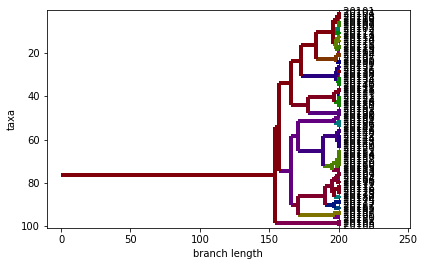

In [12]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
BioPhylo.write(
    reconstructed_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "reconstruction",
            "ext": ".nwk",
        }
    ),
    'newick',
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    teeplot_outattrs={
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=3+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=3+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.png


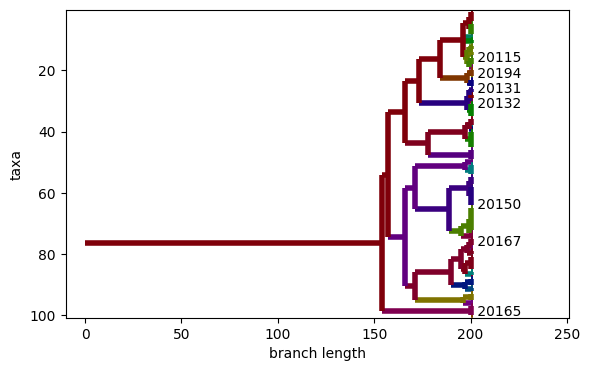

In [13]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    drop_overlapping_labels=True,
    teeplot_outattrs={
        "drop_overlapping_labels": "true",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


teeplots/./max_leaves=20+notebook=species-inference+replicate=3+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./max_leaves=20+notebook=species-inference+replicate=3+treatment=ring+type=reconstruction+viz=draw-biopython-tree+ext=.png


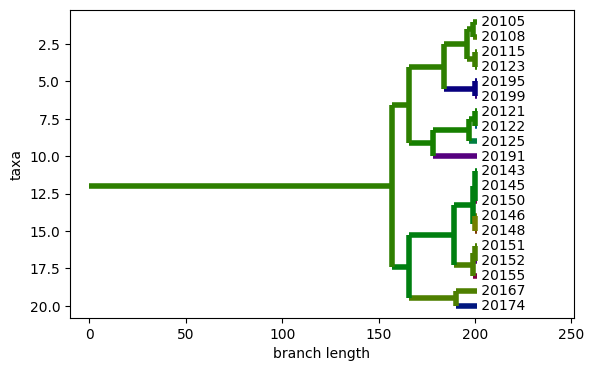

In [14]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    max_leaves=20,
    teeplot_outattrs={
        "max_leaves": "20",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


# Actual Pedigree


In [15]:
distilled_tree = pylib.deap.history_to_tree_upgma(history, extant_nodes)
BioPhylo.write(
    distilled_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "distilled-pedigree",
            "ext": ".nwk",
        }
    ),
    'newick',
)


1

teeplots/./notebook=species-inference+replicate=3+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./notebook=species-inference+replicate=3+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.png


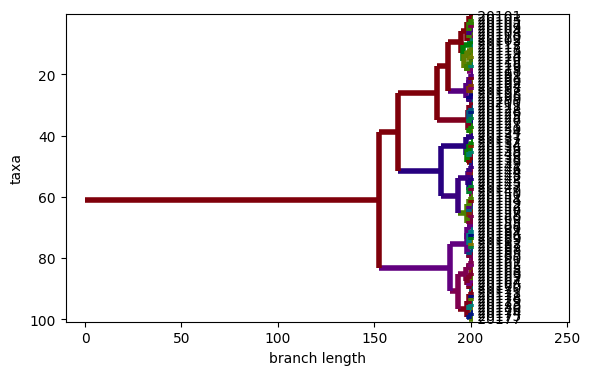

In [16]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    teeplot_outattrs={
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


teeplots/./max_leaves=20+notebook=species-inference+replicate=3+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./max_leaves=20+notebook=species-inference+replicate=3+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.png


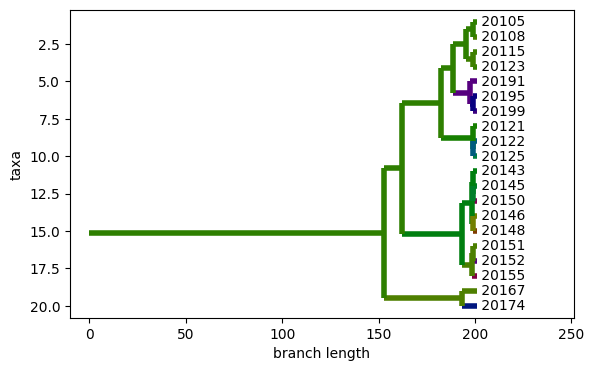

In [17]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    max_leaves=20,
    teeplot_outattrs={
        "max_leaves": "20",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=3+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./drop_overlapping_labels=true+notebook=species-inference+replicate=3+treatment=ring+type=distilled-reference+viz=draw-biopython-tree+ext=.png


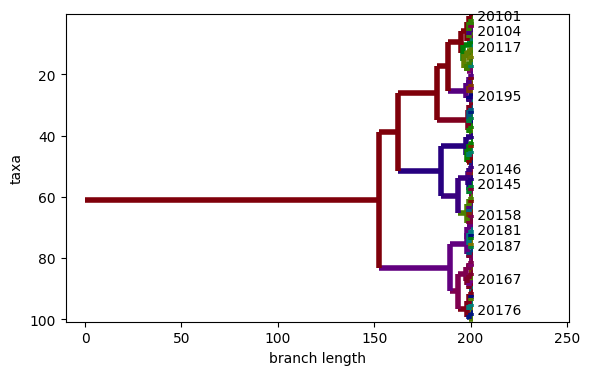

In [18]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    drop_overlapping_labels=True,
    teeplot_outattrs={
        "drop_overlapping_labels": "true",
        "notebook": "species-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


In [19]:
distilled_tree = pylib.deap.history_to_tree_upgma(
    history, extant_nodes, correct_origin_times=False
)
BioPhylo.write(
    distilled_tree,
    kn.pack(
        {
            "a": "phylogeny",
            "notebook": "species-inference",
            "replicate": str(MILL_REPLICATE),
            "treatment": MILL_TREATMENT_NAME,
            "type": "distilled-pedigree-uncorrected",
            "ext": ".nwk",
        }
    ),
    'newick',
)

quartet_dist = pylib.tree.polymorphic_quartet_distance(
    reconstructed_tree, distilled_tree
)
quartet_dist


0.23174951705143162

In [20]:
records = [
    {
        "replicate": MILL_REPLICATE,
        "treatment": MILL_TREATMENT_NAME,
        "quartet distance": quartet_dist,
    }
]
outdf = pd.DataFrame.from_records(records)
outdf.to_csv(
    kn.pack(
        {
            "a": "reconstruction-accuracy",
            "notebook": "species-inference",
            "replicate": MILL_REPLICATE,
            "treatment": MILL_TREATMENT_NAME,
            "ext": ".csv",
        }
    )
)
outdf


,replicate,treatment,quartet distance
0,3,ring,0.23175
